<a href="https://colab.research.google.com/github/tunbaruzzo/Ejemplo/blob/main/videoGamesSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Videojuegos: ¿qué determina el éxito en ventas?**


In [1]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from wordcloud import WordCloud

#Preguntas de interes
*   Que generos se vendieron más a lo largo del tiempo?
*   Qué plataformas dominan en ventas globales y cómo cambió eso por año?
*   Los juegos con cierto Rating ESRB venden más que otros?
*   Existen publishers con ventas consistentemente altas?
*   El año de lanzamiento influye en las ventas globales?







#Funciones para conectar y extraer datos de API

El dataset principal utilizado proviene de VGChartz (ventas de videojuegos) y fue enriquecido mediante una recolección adicional de datos desde Metacritic (críticas y reseñas). Es decir, la API/consulta a Metacritic ya está incorporada en esta base de datos pública, razón por la cual no fue necesario volver a consumirla directamente. Sin embargo, se incluye un bloque de código simulado de conexión a API para demostrar el proceso de adquisición de datos.

In [2]:
#instalacion
!pip install requests python-dotenv pandas tqdm rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.0 MB/s eta 0:00:00


In [3]:
#1) Imports y config
import os, time, json, math, re, unicodedata
from typing import List, Dict, Any, Optional, Tuple
import requests
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

RAWG_API_KEY = os.getenv("RAWG_API_KEY", "").strip()

BASE_URL = "https://api.rawg.io/api"
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "eda-ml-proyecto-gabi/1.0"})


In [4]:
#2) Helper: GET con paginación y manejo básico de límites
def rawg_get(endpoint: str, params: Dict[str, Any]) -> Dict[str, Any]:
    """Realiza un GET al endpoint de RAWG y devuelve el JSON."""
    url = f"{BASE_URL}/{endpoint.lstrip('/')}"
    # Adjuntamos la key siempre
    params = {**params, "key": RAWG_API_KEY} if RAWG_API_KEY else params
    r = SESSION.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def rawg_paginated(endpoint: str, params: Dict[str, Any], page_limit: int = 5, sleep_s: float = 0.8) -> List[Dict[str, Any]]:
    """
    Itera páginas de RAWG. page_limit limita cuántas páginas traemos (para demo).
    Ajustá page_limit↑ si querés más datos.
    """
    items = []
    page = 1
    for _ in range(page_limit):
        data = rawg_get(endpoint, {**params, "page": page})
        results = data.get("results", [])
        items.extend(results)
        next_url = data.get("next")
        if not next_url:
            break
        page += 1
        time.sleep(sleep_s)  # cuida rate limit
    return items


In [5]:
#3) Funciones de extracción (juegos, géneros, plataformas)
def fetch_games(dates: str = "1980-01-01,2016-12-31",
                platforms: Optional[str] = None,
                ordering: str = "-added",
                page_size: int = 40,
                page_limit: int = 5) -> List[Dict[str, Any]]:
    """
    Trae juegos de RAWG (solo para DEMO/APIs).
    - dates: rango 'YYYY-MM-DD,YYYY-MM-DD'
    - platforms: ids separados por coma (opcional). Ej: "18,1,7" (PS4, XOne, Switch...)
    - ordering: orden (p.ej. '-metacritic', '-rating', '-added')
    - page_limit: cuántas páginas (x40) bajamos
    """
    params = {
        "dates": dates,
        "page_size": page_size,
        "ordering": ordering
    }
    if platforms:
        params["platforms"] = platforms
    return rawg_paginated("games", params=params, page_limit=page_limit)

def fetch_genres() -> List[Dict[str, Any]]:
    return rawg_paginated("genres", params={"page_size": 40}, page_limit=1)

def fetch_platforms() -> List[Dict[str, Any]]:
    return rawg_paginated("platforms", params={"page_size": 40}, page_limit=10)


In [6]:
#4) Normalización a DataFrame (nos quedamos con campos útiles “pre-lanzamiento”)
def normalize_games(items: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Devuelve columnas amigables. NOTA: incluyo metacritic/ratings_count solo como referencia API;
    no los usaria para entrenar.
    """
    rows = []
    for g in items:
        rows.append({
            "rawg_id": g.get("id"),
            "name": g.get("name"),
            "released": g.get("released"),
            "year": (g.get("released")[:4] if g.get("released") else None),
            "metacritic": g.get("metacritic"),
            "ratings_count": g.get("ratings_count"),
            "genres": ", ".join([x.get("name","") for x in g.get("genres",[])]),
            "parent_platforms": ", ".join([p["platform"]["name"] for p in g.get("parent_platforms",[])]) if g.get("parent_platforms") else None,
            "platforms": ", ".join([p["platform"]["name"] for p in g.get("platforms",[])]) if g.get("platforms") else None,
            "stores": ", ".join([s["store"]["name"] for s in g.get("stores",[])]) if g.get("stores") else None
        })
    return pd.DataFrame(rows)

def normalize_simple(items: List[Dict[str, Any]], key_fields: List[str]) -> pd.DataFrame:
    """Normaliza recursos simples (géneros, plataformas)."""
    norm = []
    for it in items:
        row = {k: it.get(k) for k in key_fields}
        norm.append(row)
    return pd.DataFrame(norm)


In [7]:
#5) Guardado local (CSV/JSON)
def save_json(filepath: str, data: Any) -> None:
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

def save_csv(df: pd.DataFrame, filepath: str) -> None:
    df.to_csv(filepath, index=False, encoding="utf-8")


#Carga de datos

In [8]:
url = "https://raw.githubusercontent.com/tunbaruzzo/proyecto-videojuegos-ml-BARUZZO/refs/heads/main/Data"
df = pd.read_csv(url)

print(df.shape)
df.head()


(16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


#DATA WRANGLING

1.Resumen de valores nulos

In [10]:
# Resumen de nulos en cantidad y porcentaje
nulos = df.isna().sum().reset_index()
nulos.columns = ["columna", "nulos"]

nulos["%_nulos"] = (nulos["nulos"] / len(df) * 100).round(2)

# Ordenamos de mayor a menor
nulos = nulos.sort_values("%_nulos", ascending=False)

nulos


,columna,nulos,%_nulos
12,User_Score,9129,54.60
13,User_Count,9129,54.60
10,Critic_Score,8582,51.33
11,Critic_Count,8582,51.33
15,Rating,6769,40.49
14,Developer,6623,39.61
2,Year_of_Release,269,1.61
4,Publisher,54,0.32
0,Name,2,0.01
3,Genre,2,0.01


#Análisis de los nulos
##Muy altos (>50%)

User_Score (54.6%)

User_Count (54.6%)

Critic_Score (51.3%)

Critic_Count (51.3%)

Estos vienen de Metacritic y son post-lanzamiento, así que directamente los dejamos fuera del análisis/modelo.
##Altos (~40%)

Rating (40.5%)

Developer (39.6%)

Developer: demasiado faltante → descartado.
Rating: conviene mantenerlo, porque la clasificación ESRB es importante. Los nulos los reemplazo por "Unknown".
##Moderados / bajos

Year_of_Release (1.6%) → es clave para todo (ventas, tendencias). Mejor eliminar esas ~269 filas nulas.

Publisher (0.3%) → pocos faltantes, reemplazo por "Unknown".
##Muy bajos (0.01%)

Name y Genre: solo 2 nulos → eliminarlos sin problema.
##Sin nulos (0%)

Platform, todas las ventas (NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales).

Perfectas, no requieren cambios.

In [11]:
#Copia de trabajo (para no tocar df original)
df_pl = df.copy()
print(df_pl.shape)


(16719, 16)


In [12]:
#Eliminar columnas que no usamos (Metacritic + Developer)
#Columnas post-lanzamiento o con muchos nulos que NO uso en pre-lanzamiento
cols_drop = ["Critic_Score", "Critic_Count", "User_Score", "User_Count", "Developer"]

df_pl = df_pl.drop(columns=[c for c in cols_drop if c in df_pl.columns])
df_pl.shape


(16719, 11)

In [13]:
#Eliminar filas sin año de lanzamiento
#Year_of_Release es clave; quito filas donde falte
antes = len(df_pl)
df_pl = df_pl[df_pl["Year_of_Release"].notna()].copy()
despues = len(df_pl)
print(f"Filas removidas por Year_of_Release nulo: {antes - despues}")
df_pl.shape

Filas removidas por Year_of_Release nulo: 269


(16450, 11)

In [14]:
#Eliminar filas con Name o Genre nulos (son muy pocas)
antes = len(df_pl)
df_pl = df_pl[df_pl["Name"].notna() & df_pl["Genre"].notna()].copy()
despues = len(df_pl)
print(f"Filas removidas por Name/Genre nulos: {antes - despues}")
df_pl.shape

Filas removidas por Name/Genre nulos: 2


(16448, 11)

In [15]:
#Imputar Publisher y Rating faltantes
# Publisher pocos nulos -> 'Unknown'
if "Publisher" in df_pl.columns:
    df_pl["Publisher"] = df_pl["Publisher"].fillna("Unknown")

# Rating muchos nulos -> 'Unknown' (lo tratamos como categoría válida)
if "Rating" in df_pl.columns:
    df_pl["Rating"] = df_pl["Rating"].fillna("Unknown")

df_pl[["Publisher","Rating"]].isna().sum()

,0
Publisher,0
Rating,0


In [16]:
#Limpieza ligera de strings (trim)
for col in ["Name", "Platform", "Genre", "Publisher", "Rating"]:
    if col in df_pl.columns:
        df_pl[col] = df_pl[col].astype(str).str.strip()

In [17]:
#Convertir tipos numéricos (Year a entero “nullable”)
#Aseguro numéricos
df_pl["Year_of_Release"] = pd.to_numeric(df_pl["Year_of_Release"], errors="coerce").astype("Int64")

for col in ["Global_Sales", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]:
    if col in df_pl.columns:
        df_pl[col] = pd.to_numeric(df_pl[col], errors="coerce")

df_pl.dtypes

,0
Name,object
Platform,object
Year_of_Release,Int64
Genre,object
Publisher,object
NA_Sales,float64
EU_Sales,float64
JP_Sales,float64
Other_Sales,float64
Global_Sales,float64


In [18]:
#Chequeo rápido de nulos post-limpieza
nulos_post = (df_pl.isna().sum() / len(df_pl) * 100).round(2).sort_values(ascending=False)
nulos_post

,0
Name,0.0
Platform,0.0
Year_of_Release,0.0
Genre,0.0
Publisher,0.0
NA_Sales,0.0
EU_Sales,0.0
JP_Sales,0.0
Other_Sales,0.0
Global_Sales,0.0


In [19]:
#Features básicos para EDA: Year (int), Decade, Rating_filled
df_pl["Year"] = df_pl["Year_of_Release"].astype(int)
df_pl["Decade"] = (df_pl["Year"] // 10) * 10
df_pl["Rating_filled"] = df_pl["Rating"]  # ya imputado como 'Unknown'

df_pl[["Year","Decade","Rating","Rating_filled"]].head(3)

,Year,Decade,Rating,Rating_filled
0,2006,2000,E,E
1,1985,1980,Unknown,Unknown
2,2008,2000,E,E


In [20]:
#Guardar dataset listo para EDA
OUT_CSV = "vgames_pre_lanzamiento_clean.csv"
df_pl.to_csv(OUT_CSV, index=False, encoding="utf-8")
print("Guardado:", OUT_CSV, "| forma:", df_pl.shape)

Guardado: vgames_pre_lanzamiento_clean.csv | forma: (16448, 14)



2. Limpieza y tratamiento de valores faltantes

Antes del análisis exploratorio, se revisó la calidad de los datos.  
Se identificaron variables con alto porcentaje de valores faltantes, especialmente aquellas asociadas a evaluaciones *post-lanzamiento* (Metacritic y usuarios), que no resultan útiles para el análisis *pre-lanzamiento*.

A continuación, se resumen los principales pasos aplicados:

| Tipo de tratamiento | Columnas afectadas | Acción realizada | Motivo |
|---------------------|-------------------|------------------|--------|
| Eliminación de columnas | `Critic_Score`, `Critic_Count`, `User_Score`, `User_Count`, `Developer` | Eliminadas | Variables disponibles solo tras el lanzamiento o con más del 50% de nulos |
| Eliminación de filas | `Year_of_Release`, `Name`, `Genre` | Eliminadas 271 filas | Son campos clave para la identificación del juego |
| Imputación de valores | `Publisher`, `Rating` | Reemplazados nulos por “Unknown” | Mantener consistencia y permitir análisis sin sesgos por exclusión |

Tras la limpieza, el dataset pasó de **16.719 filas** a **16.448 filas**, manteniendo **11 columnas** relevantes para el análisis.


In [21]:
# Resumen visual de nulos antes del tratamiento
nulos = df_pl.isna().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)
porc_nulos = (nulos / len(df_pl)) * 100
tabla_nulos = pd.DataFrame({"nulos": nulos, "%_nulos": porc_nulos.round(2)})
display(tabla_nulos)

# Confirmar que no quedan valores faltantes en las columnas clave
df_pl[["Publisher", "Rating", "Year_of_Release", "Genre", "Name"]].isna().sum()


,nulos,%_nulos


,0
Publisher,0
Rating,0
Year_of_Release,0
Genre,0
Name,0


#ANALISIS EXPLORATORIO

Números generales (conteos y rango temporal)

In [22]:
resumen_generales = {
    "juegos_totales": len(df_pl),
    "plataformas_distintas": df_pl["Platform"].nunique(),
    "generos_distintos": df_pl["Genre"].nunique(),
    "publishers_distintos": df_pl["Publisher"].nunique(),
    "rango_anios": (int(df_pl["Year"].min()), int(df_pl["Year"].max())),
}

resumen_generales


{'juegos_totales': 16448,
 'plataformas_distintas': 31,
 'generos_distintos': 12,
 'publishers_distintos': 579,
 'rango_anios': (1980, 2020)}

Estadísticas de ventas (globales y por juego)

In [23]:
ventas_total_global = df_pl["Global_Sales"].sum()
ventas_promedio_por_juego = df_pl["Global_Sales"].mean()
juego_top = df_pl.loc[df_pl["Global_Sales"].idxmax(), ["Name","Platform","Year","Global_Sales"]]

resumen_ventas = {
    "ventas_globales_totales": round(ventas_total_global, 2),
    "ventas_promedio_por_juego": round(ventas_promedio_por_juego, 2),
    "juego_top_name": juego_top["Name"],
    "juego_top_platform": juego_top["Platform"],
    "juego_top_year": int(juego_top["Year"]),
    "juego_top_global_sales": round(float(juego_top["Global_Sales"]), 2),
}

resumen_ventas

{'ventas_globales_totales': np.float64(8818.92),
 'ventas_promedio_por_juego': np.float64(0.54),
 'juego_top_name': 'Wii Sports',
 'juego_top_platform': 'Wii',
 'juego_top_year': 2006,
 'juego_top_global_sales': 82.53}

Distribución de ventas

In [24]:
dist_global_sales = df_pl["Global_Sales"].describe()
dist_global_sales

,Global_Sales
count,16448.00000
mean,0.53617
std,1.55846
min,0.01000
25%,0.06000
50%,0.17000
75%,0.47000
max,82.53000


“¿Qué porcentaje…?” (ratings, géneros y publishers top)

In [25]:
# % de juegos por rating (incluye Unknown)
porc_rating = (df_pl["Rating_filled"]
               .value_counts(normalize=True)
               .mul(100).round(2))

# % de ventas globales por género (top 10)
ventas_por_genero = (df_pl.groupby("Genre")["Global_Sales"]
                     .sum()
                     .sort_values(ascending=False))
porc_ventas_genero = ventas_por_genero.div(ventas_por_genero.sum()).mul(100).round(2).head(10)

# % de juegos lanzados por los 5 publishers con más títulos
top_publishers = df_pl["Publisher"].value_counts().head(5)
porc_top_publishers_juegos = round(top_publishers.sum() / len(df_pl) * 100, 2)

{
    "porcentaje_juegos_por_rating(%)": porc_rating.to_dict(),
    "porcentaje_ventas_por_genero_top10(%)": porc_ventas_genero.to_dict(),
    "porcentaje_juegos_de_top5_publishers(%)": porc_top_publishers_juegos
}

{'porcentaje_juegos_por_rating(%)': {'Unknown': 40.61,
  'E': 23.84,
  'T': 17.66,
  'M': 9.34,
  'E10+': 8.47,
  'EC': 0.05,
  'K-A': 0.02,
  'AO': 0.01,
  'RP': 0.01},
 'porcentaje_ventas_por_genero_top10(%)': {'Action': 19.48,
  'Sports': 14.86,
  'Shooter': 11.81,
  'Role-Playing': 10.56,
  'Platform': 9.36,
  'Misc': 8.97,
  'Racing': 8.21,
  'Fighting': 5.02,
  'Simulation': 4.4,
  'Puzzle': 2.73},
 'porcentaje_juegos_de_top5_publishers(%)': np.float64(30.46)}

Nube de palabras

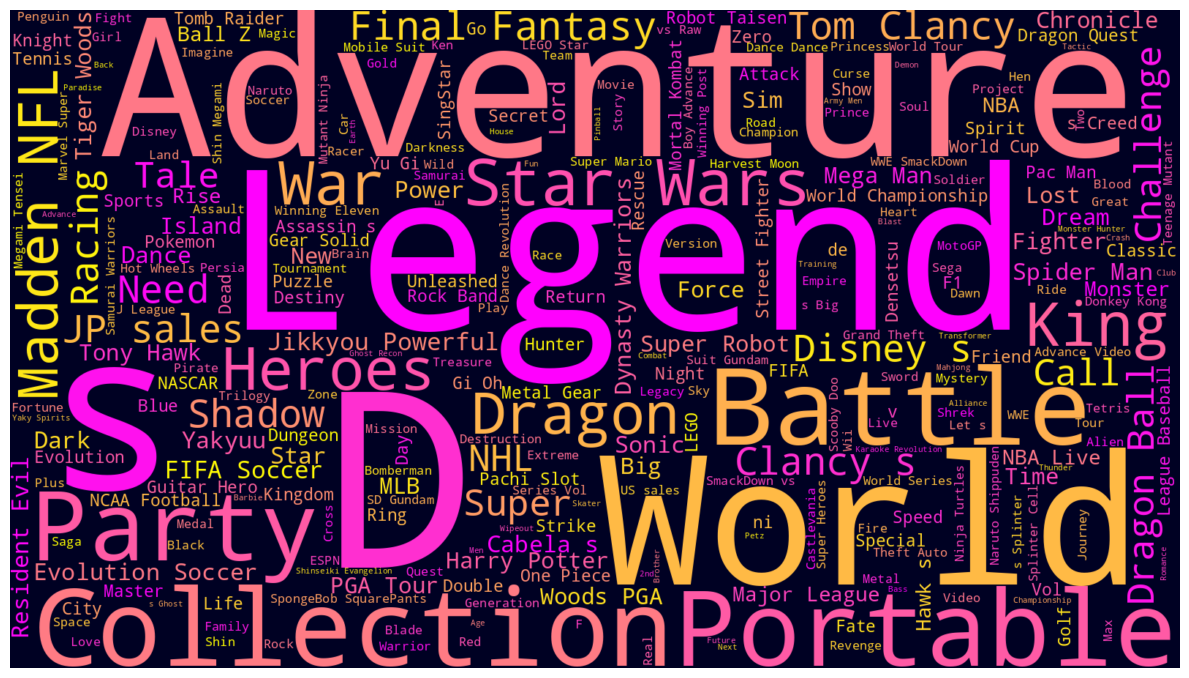

In [26]:
# Unimos todos los títulos en un solo string
titulos = df_pl["Name"].dropna().astype(str).tolist()
texto_titulos = " ".join(titulos)
len(texto_titulos)
# Si no lo tenés instalado, una vez:
# !pip install wordcloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

# Stopwords básicas + algunas específicas de títulos
stop_extra = {
    "the","of","and","for","in","edition","game","games","deluxe","ultimate","pro",
    "hd","3d","iv","ii","iii","x","xl","dx","goty","pack","bundle"
}
stops = STOPWORDS.union(stop_extra)

# Limpiamos números sueltos y símbolos
texto_limpio = re.sub(r"[^A-Za-z0-9\s]", " ", texto_titulos)
texto_limpio = re.sub(r"\b\d+\b", " ", texto_limpio)
texto_limpio = re.sub(r"\s+", " ", texto_limpio).strip()

# Creamos la nube con mi estética
wc = WordCloud(
    width=1600, height=900,
    background_color="#000123",   # mi color de fondo
    colormap="spring",            # fucsias/rosas, para que combine con #ff0f7b
    stopwords=stops,
    collocations=True,
    max_words=300
).generate(texto_limpio)

# Mostrar en Colab
plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

# Guardar imagen para usar en la presentación
wc.to_file("wordcloud_titulos_dark.png")

##1-¿Qué géneros han vendido más a lo largo del tiempo?

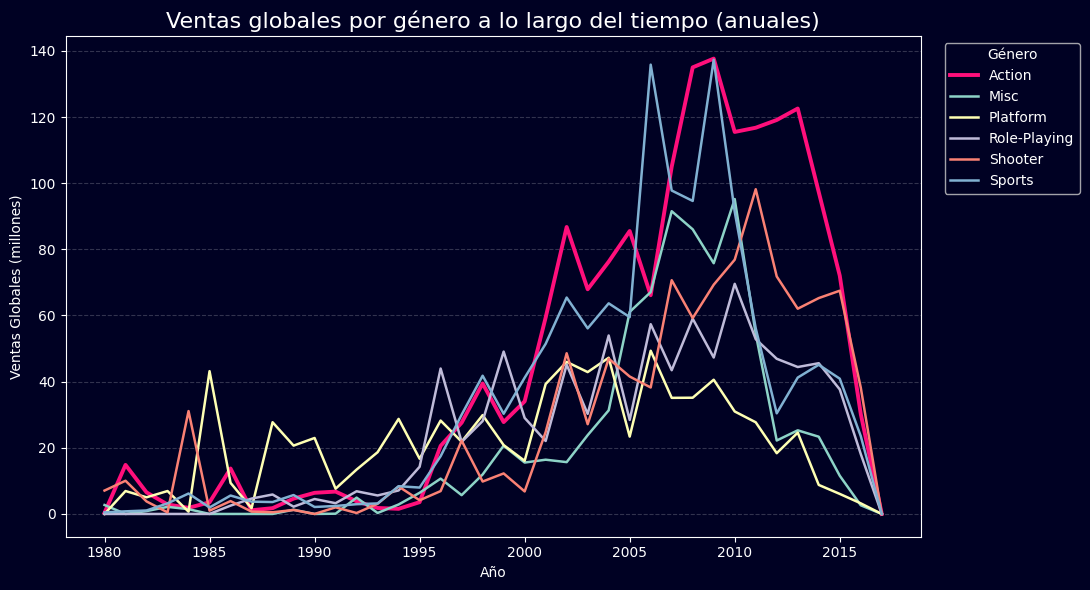

{'top_generos': ['Action',
  'Sports',
  'Shooter',
  'Role-Playing',
  'Platform',
  'Misc'],
 'imagen': 'q1_generos_tiempo.png'}

In [27]:
def grafico_generos_en_el_tiempo(df, top_n=6, save_path="q1_generos_tiempo.png"):
    """
    Grafica la evolución anual de ventas globales para los TOP N géneros.
    - df: DataFrame limpio (df_pl) con columnas: ['Year','Genre','Global_Sales']
    - top_n: cantidad de géneros a mostrar
    """
    # 1) Top géneros por ventas totales históricas
    top_generos = (df.groupby("Genre")["Global_Sales"]
                     .sum()
                     .sort_values(ascending=False)
                     .head(top_n)
                     .index.tolist())

    # 2) Serie anual por género (solo los top_generos)
    anuales = (df[df["Genre"].isin(top_generos)]
               .groupby(["Year","Genre"])["Global_Sales"]
               .sum()
               .reset_index())

    # 3) Pivot (Years x Genres)
    pivot = anuales.pivot(index="Year", columns="Genre", values="Global_Sales").fillna(0)
    pivot = pivot.sort_index()

    # 4) Estilo global
    plt.style.use("dark_background")
    plt.rcParams.update({
        "axes.facecolor": "#000123",
        "figure.facecolor": "#000123",
        "savefig.facecolor": "#000123",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "grid.color": "white",
        "grid.linestyle": "--",
        "grid.alpha": 0.2
    })

    # 5) Plot
    plt.figure(figsize=(11,6))
    for col in pivot.columns:
        # Usamos el fucsia para destacar el líder histórico y blanco/gris para el resto
        if col == pivot.sum().idxmax():  # género líder total
            plt.plot(pivot.index, pivot[col], linewidth=2.8, label=col, color="#ff0f7b")
        else:
            plt.plot(pivot.index, pivot[col], linewidth=1.8, label=col)

    plt.title("Ventas globales por género a lo largo del tiempo (anuales)", fontsize=16)
    plt.xlabel("Año")
    plt.ylabel("Ventas Globales (millones)")
    plt.grid(True, axis="y")

    # Leyenda fuera para no tapar la figura
    plt.legend(title="Género", loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

    return {"top_generos": top_generos, "imagen": save_path}

# Ejecución de ejemplo:
grafico_generos_en_el_tiempo(df_pl, top_n=6, save_path="q1_generos_tiempo.png")


Descartamos ese grafico porque tiene mucho ruido. Probamos colocar los "mas importantes".

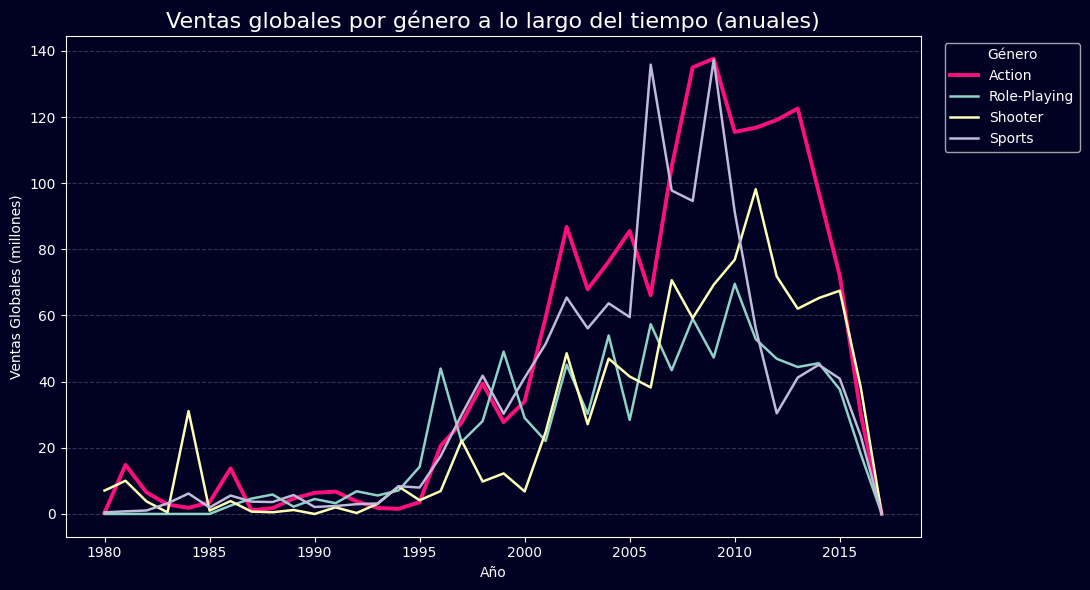

{'top_generos': ['Action', 'Sports', 'Shooter', 'Role-Playing'],
 'imagen': 'q1_generos_top4.png'}

In [28]:
grafico_generos_en_el_tiempo(df_pl, top_n=4, save_path="q1_generos_top4.png")

Persiste el ruido, probamos reflejarlo de otra manera.

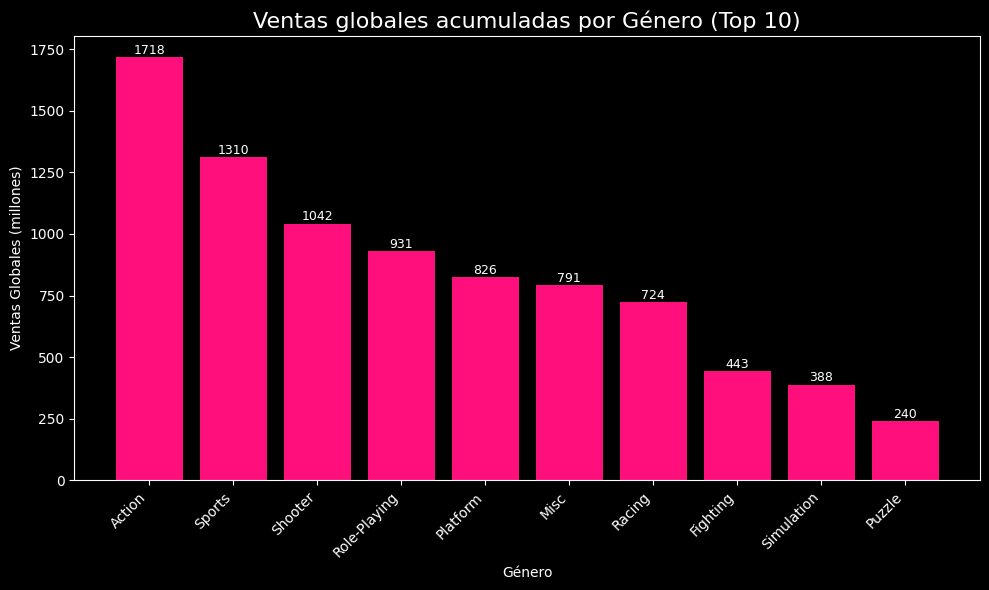

In [29]:
def grafico_generos_totales(df, top_n=10, save_path="q1_generos_totales.png"):
    ventas = (df.groupby("Genre")["Global_Sales"]
                .sum()
                .sort_values(ascending=False)
                .head(top_n))

    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    bars = plt.bar(ventas.index, ventas.values, color="#ff0f7b")

    plt.title("Ventas globales acumuladas por Género (Top 10)", fontsize=16, color="white")
    plt.xlabel("Género", color="white")
    plt.ylabel("Ventas Globales (millones)", color="white")
    plt.xticks(rotation=45, ha="right", color="white")
    plt.yticks(color="white")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval+1, f"{yval:.0f}",
                 ha="center", va="bottom", color="white", fontsize=9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_generos_totales(df_pl)

##2- ¿Qué plataformas dominan en ventas globales y cómo cambió eso por año?

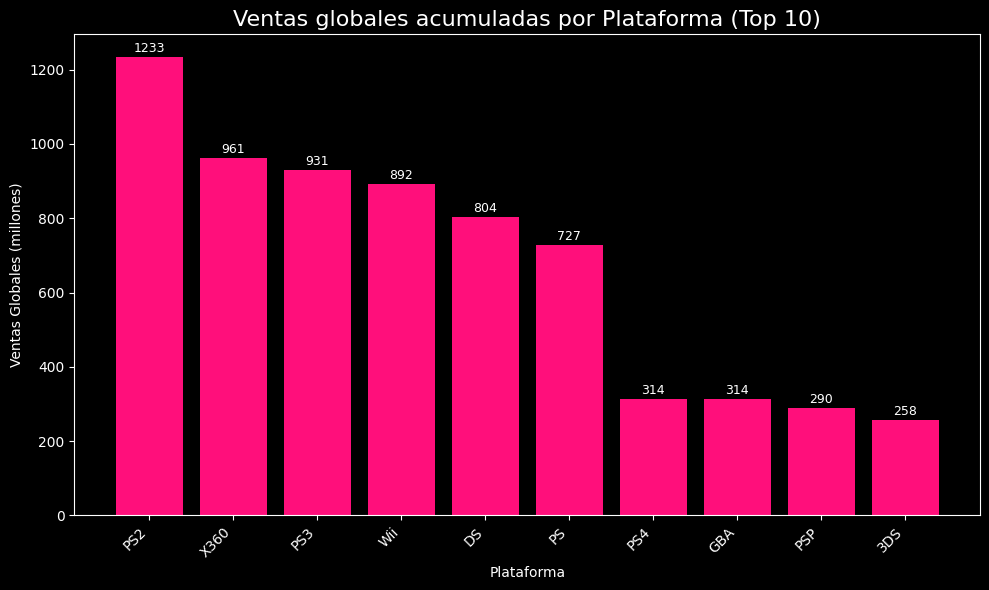

In [30]:
#plataformas que más vendieron históricamente
def grafico_plataformas_totales(df, top_n=10, save_path="q2_plataformas_totales.png"):
    ventas = (df.groupby("Platform")["Global_Sales"]
                .sum()
                .sort_values(ascending=False)
                .head(top_n))

    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    bars = plt.bar(ventas.index, ventas.values, color="#ff0f7b")

    plt.title("Ventas globales acumuladas por Plataforma (Top 10)", fontsize=16, color="white")
    plt.xlabel("Plataforma", color="white")
    plt.ylabel("Ventas Globales (millones)", color="white")
    plt.xticks(rotation=45, ha="right", color="white")
    plt.yticks(color="white")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval+5, f"{yval:.0f}",
                 ha="center", va="bottom", color="white", fontsize=9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_plataformas_totales(df_pl)

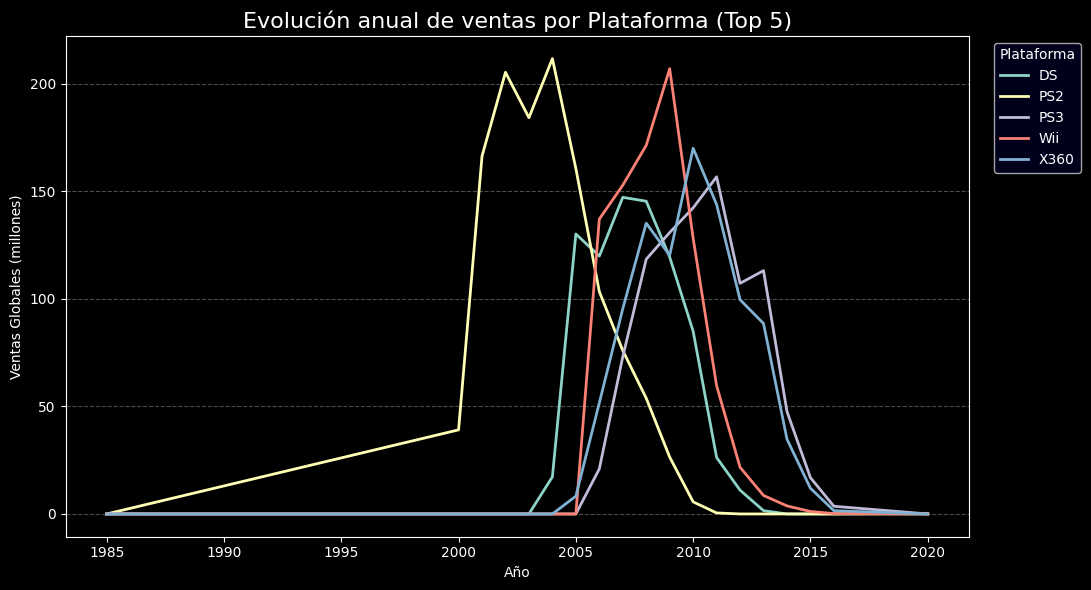

In [31]:
#Evolución temporal de las plataformas líderes
def grafico_plataformas_en_el_tiempo(df, top_n=5, save_path="q2_plataformas_tiempo.png"):
    # Top plataformas por ventas acumuladas
    top_plat = (df.groupby("Platform")["Global_Sales"]
                  .sum()
                  .sort_values(ascending=False)
                  .head(top_n)
                  .index.tolist())

    anuales = (df[df["Platform"].isin(top_plat)]
               .groupby(["Year","Platform"])["Global_Sales"]
               .sum()
               .reset_index())

    pivot = anuales.pivot(index="Year", columns="Platform", values="Global_Sales").fillna(0)

    plt.style.use("dark_background")
    plt.figure(figsize=(11,6))

    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], linewidth=2, label=col)

    plt.title("Evolución anual de ventas por Plataforma (Top 5)", fontsize=16, color="white")
    plt.xlabel("Año", color="white")
    plt.ylabel("Ventas Globales (millones)", color="white")
    plt.xticks(color="white")
    plt.yticks(color="white")
    plt.grid(True, axis="y", linestyle="--", alpha=0.3)

    plt.legend(title="Plataforma", loc="upper left", bbox_to_anchor=(1.02,1), facecolor="#000123")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_plataformas_en_el_tiempo(df_pl)

##¿Los juegos con cierto Rating ESRB venden más que otros?

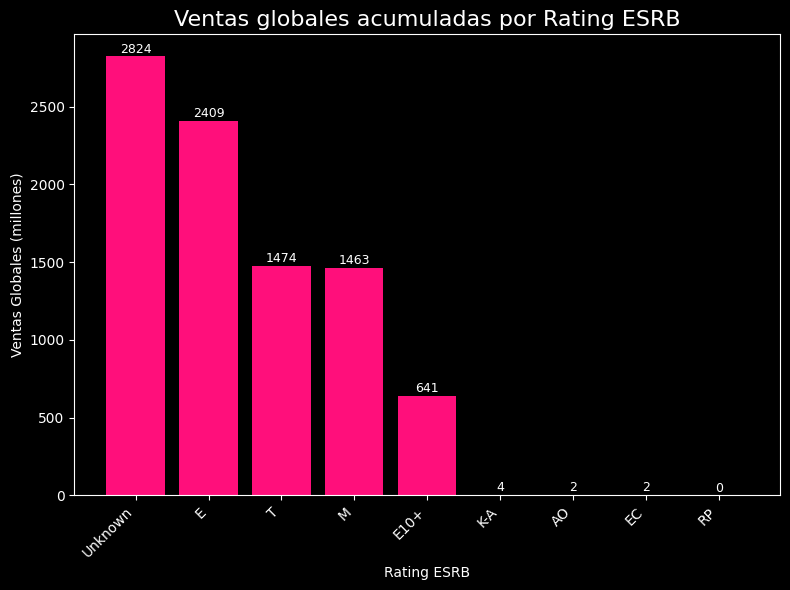

In [32]:
def grafico_rating_totales(df, save_path="q3_rating_totales.png"):
    ventas = (df.groupby("Rating_filled")["Global_Sales"]
                .sum()
                .sort_values(ascending=False))

    plt.style.use("dark_background")
    plt.figure(figsize=(8,6))
    bars = plt.bar(ventas.index, ventas.values, color="#ff0f7b")

    plt.title("Ventas globales acumuladas por Rating ESRB", fontsize=16, color="white")
    plt.xlabel("Rating ESRB", color="white")
    plt.ylabel("Ventas Globales (millones)", color="white")
    plt.xticks(rotation=45, ha="right", color="white")
    plt.yticks(color="white")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval+5, f"{yval:.0f}",
                 ha="center", va="bottom", color="white", fontsize=9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_rating_totales(df_pl)


/tmp/ipython-input-2840039365.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


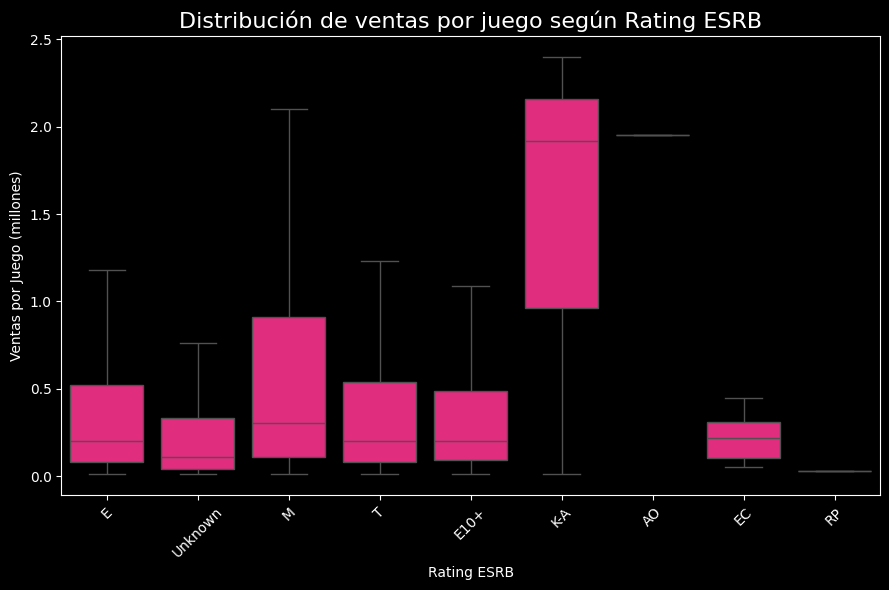

In [33]:
import seaborn as sns

def grafico_rating_boxplot(df, save_path="q3_rating_boxplot.png"):
    plt.style.use("dark_background")
    plt.figure(figsize=(9,6))

    sns.boxplot(
        data=df,
        x="Rating_filled",
        y="Global_Sales",
        palette=["#ff0f7b"]*df["Rating_filled"].nunique(),
        showfliers=False   # no mostrar outliers extremos
    )

    plt.title("Distribución de ventas por juego según Rating ESRB", fontsize=16, color="white")
    plt.xlabel("Rating ESRB", color="white")
    plt.ylabel("Ventas por Juego (millones)", color="white")
    plt.xticks(rotation=45, color="white")
    plt.yticks(color="white")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_rating_boxplot(df_pl)

##¿Qué publishers han logrado ventas consistentemente altas?

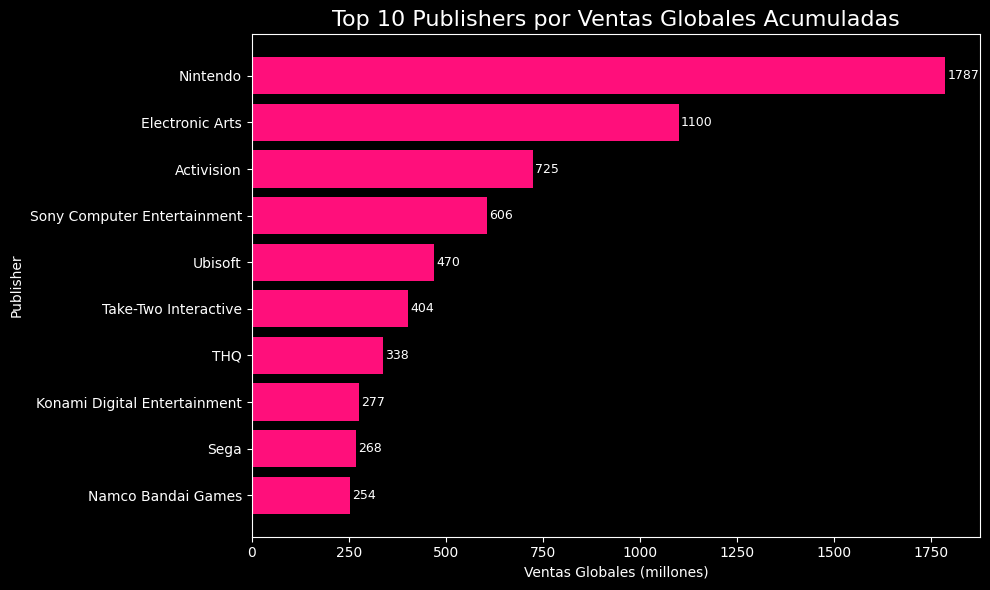

In [34]:
#Top publishers por ventas acumuladas
def grafico_top_publishers(df, top_n=10, save_path="q4_top_publishers.png"):
    ventas = (df.groupby("Publisher")["Global_Sales"]
                .sum()
                .sort_values(ascending=False)
                .head(top_n))

    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    bars = plt.barh(ventas.index[::-1], ventas.values[::-1], color="#ff0f7b")

    plt.title(f"Top {top_n} Publishers por Ventas Globales Acumuladas", fontsize=16, color="white")
    plt.xlabel("Ventas Globales (millones)", color="white")
    plt.ylabel("Publisher", color="white")
    plt.xticks(color="white")
    plt.yticks(color="white")

    for bar in bars:
        plt.text(bar.get_width()+5, bar.get_y()+bar.get_height()/2,
                 f"{bar.get_width():.0f}",
                 va="center", color="white", fontsize=9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_top_publishers(df_pl)

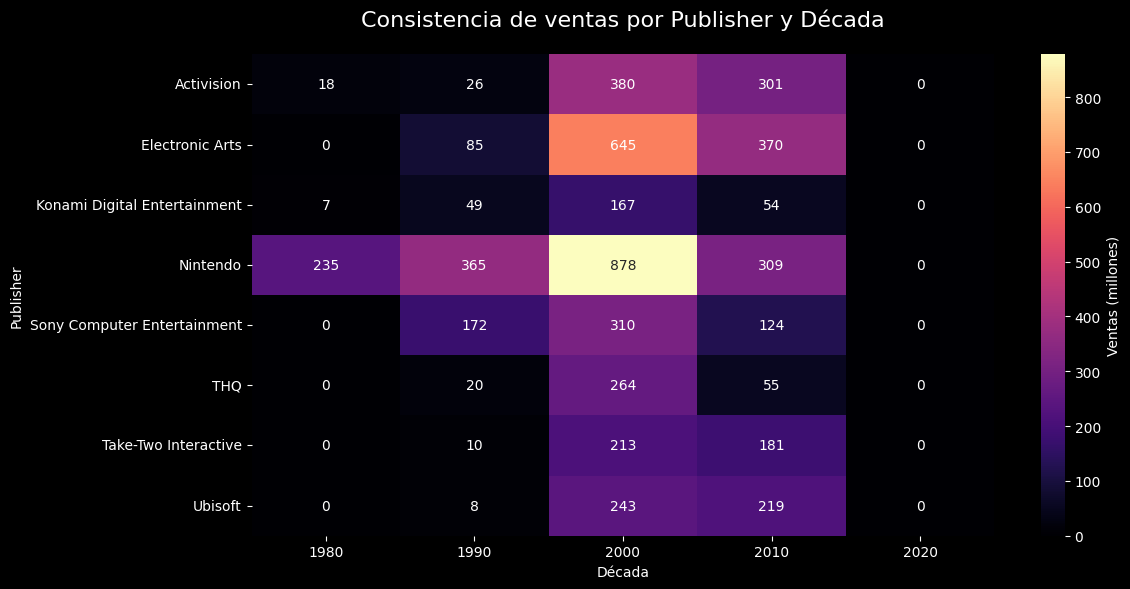

In [35]:
#Consistencia por década (heatmap opcional)
import seaborn as sns

def grafico_publishers_consistencia(df, top_n=8, save_path="q4_publishers_consistencia.png"):
    # Elegir top publishers acumulados
    top_publishers = (df.groupby("Publisher")["Global_Sales"]
                        .sum()
                        .sort_values(ascending=False)
                        .head(top_n)
                        .index)

    # Tabla de ventas por década
    tabla = (df[df["Publisher"].isin(top_publishers)]
             .pivot_table(values="Global_Sales",
                          index="Publisher",
                          columns="Decade",
                          aggfunc="sum",
                          fill_value=0))

    plt.figure(figsize=(12,6))
    sns.heatmap(tabla, cmap="magma", annot=True, fmt=".0f", cbar_kws={'label': 'Ventas (millones)'})

    plt.title("Consistencia de ventas por Publisher y Década", fontsize=16, color="white", pad=20)
    plt.xlabel("Década")
    plt.ylabel("Publisher")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_publishers_consistencia(df_pl)

##¿El año de lanzamiento influye en las ventas globales?

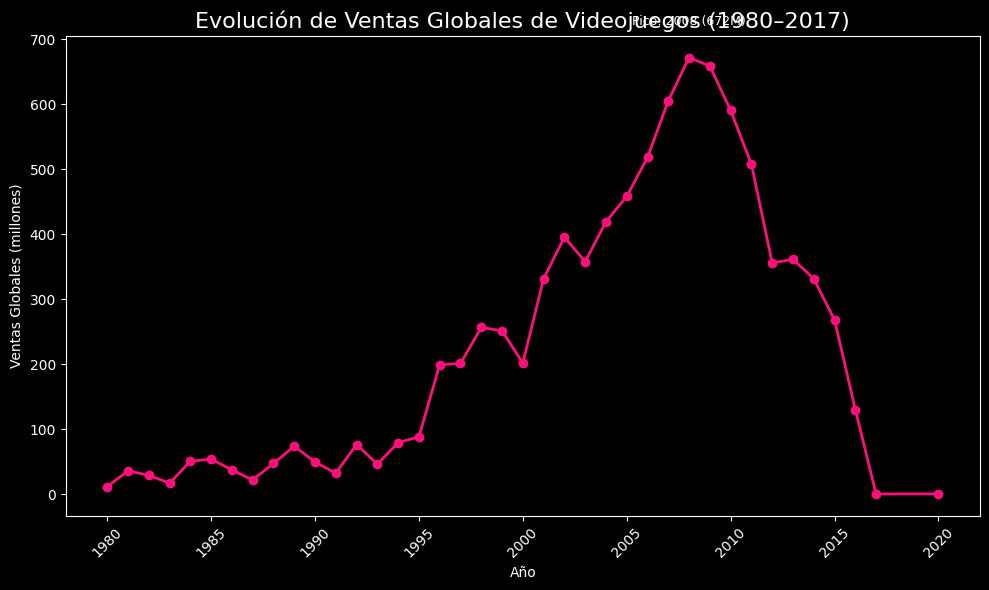

In [36]:
#Evolución anual de ventas globales
def grafico_ventas_por_anio(df, save_path="q5_ventas_anuales.png"):
    ventas_anuales = (df.groupby("Year")["Global_Sales"]
                        .sum()
                        .reset_index())

    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    plt.plot(ventas_anuales["Year"], ventas_anuales["Global_Sales"],
             marker="o", color="#ff0f7b", linewidth=2)

    plt.title("Evolución de Ventas Globales de Videojuegos (1980–2017)", fontsize=16, color="white")
    plt.xlabel("Año", color="white")
    plt.ylabel("Ventas Globales (millones)", color="white")
    plt.xticks(rotation=45, color="white")
    plt.yticks(color="white")

    # Añadir etiquetas en los máximos
    pico = ventas_anuales.loc[ventas_anuales["Global_Sales"].idxmax()]
    plt.text(pico["Year"], pico["Global_Sales"]+50,
             f"Pico: {int(pico['Year'])} ({pico['Global_Sales']:.0f}M)",
             color="white", fontsize=9, ha="center")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor="#000123")
    plt.show()

# Llamada
grafico_ventas_por_anio(df_pl)

#CONCLUSIONES

##Insights por pregunta

1. Géneros más vendidos

Action, Sports y Shooter concentran la mayor parte de las ventas globales.

Los géneros de nicho (Puzzle, Strategy) tienen menor impacto comercial.

2. Plataformas dominantes

Consolas como PS2, Wii y DS marcaron picos históricos de ventas.

Se observa un cambio generacional: las plataformas dominantes van rotando cada ~10 años.

3. Rating ESRB y ventas

Los juegos con clasificación “E” (Everyone) y “T” (Teen) acumulan más ventas globales.

Los juegos “Mature” también muestran alto volumen, indicando un mercado sólido para público adulto.

Una porción importante de juegos aparece como Unknown, lo que refleja limitaciones en los datos.

4. Publishers líderes

Nintendo, Electronic Arts y Activision son los que más ventas globales acumularon.

Nintendo se destaca por consistencia: logró altos volúmenes en varias décadas.

5. Año de lanzamiento y ventas

Hubo un pico de ventas globales entre 2006 y 2009, coincidiendo con el boom de Wii, DS y títulos de alto impacto (ej: Wii Sports, Mario Kart).

En años recientes (post 2012) se observa una caída, posiblemente vinculada al cambio en modelos de negocio (digital, mobile).

##Pros

El dataset permite observar claramente patrones históricos en géneros, plataformas y publishers.

Identifica factores pre-lanzamiento que pueden asociarse al éxito (género, plataforma, rating, publisher).

##Contras

Datos incompletos en algunas variables (ej: Rating con 40% faltantes).

El análisis no incluye reseñas de críticos/usuarios (información post-lanzamiento).

Ventas digitales modernas no están completamente representadas en el dataset.

##Recomendaciones

Para publishers y estudios: apostar a géneros masivos (Action, Sports, Shooter) sigue siendo una estrategia segura.

Los ratings amplios (E, T) permiten llegar a más público y tienden a correlacionar con mayores ventas globales.

Las plataformas líderes cambian con cada generación, por lo que la elección de plataforma al momento del lanzamiento es un factor crítico.

Nintendo se muestra como un caso de estrategia consistente, lo que indica que mantener franquicias fuertes a lo largo del tiempo es clave.

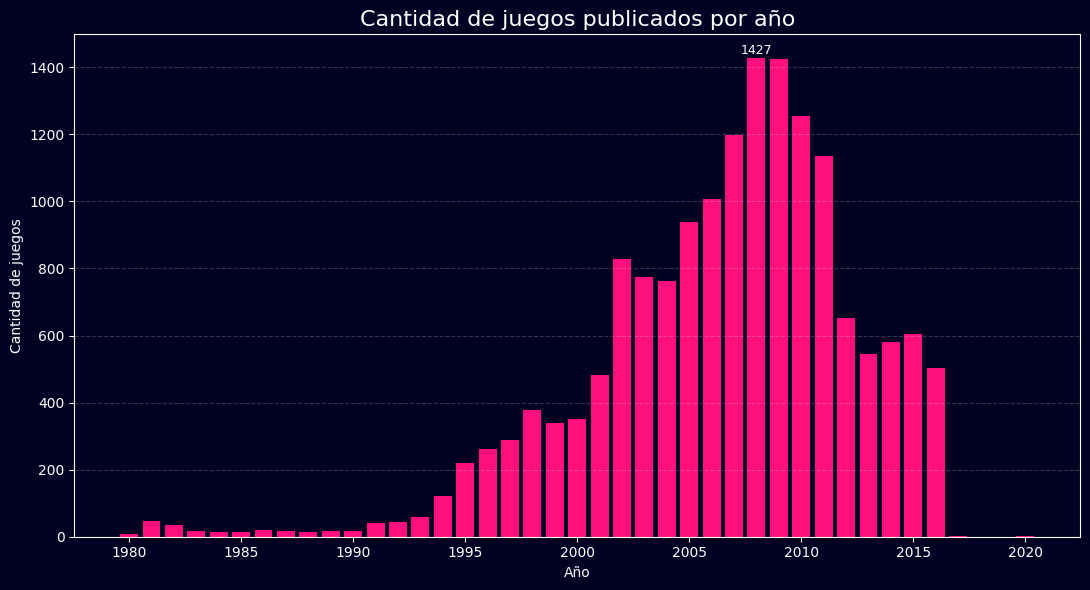

,Year,count
29,2009,1426
30,2010,1255
31,2011,1136
32,2012,653
33,2013,544
34,2014,581
35,2015,606
36,2016,502
37,2017,3
38,2020,1


In [37]:
#Extra para mi presentacion
#Resumen Metadata
import matplotlib.pyplot as plt
import pandas as pd

def juegos_por_anio(df, save_path="meta_juegos_por_anio.png"):
    # Conteo por año (ordenado)
    conteo = (df.groupby("Year")
                .size()
                .reset_index(name="count")
                .sort_values("Year"))

    # Estilo / colores
    plt.style.use("dark_background")
    plt.rcParams.update({
        "axes.facecolor": "#000123",
        "figure.facecolor": "#000123",
        "savefig.facecolor": "#000123",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "grid.color": "white",
        "grid.linestyle": "--",
        "grid.alpha": 0.2
    })

    # Plot
    plt.figure(figsize=(11,6))
    bars = plt.bar(conteo["Year"], conteo["count"], color="#ff0f7b")

    plt.title("Cantidad de juegos publicados por año", fontsize=16)
    plt.xlabel("Año")
    plt.ylabel("Cantidad de juegos")
    plt.grid(True, axis="y")

    # Etiquetas (opcionales): solo en picos para no saturar
    pico = conteo.loc[conteo["count"].idxmax()]
    plt.text(pico["Year"], pico["count"]+5, f"{int(pico['count'])}",
             ha="center", va="bottom", fontsize=9, color="white")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    return conteo.tail(10)  # devuelve los últimos años como mini resumen

# Ejecutar
juegos_por_anio(df_pl)


#BLOQUE PREDICTIVO (modelo simple)

###Objetivo

Predecir si un videojuego tendrá ventas globales altas usando solo variables conocidas antes del lanzamiento (como Platform, Genre, Publisher, Year, Rating).

In [38]:
# Paso 1 – Crear variable objetivo
# Primero, definimos una etiqueta binaria ventas_altas: Esto nos permite ver el balance entre juegos exitosos y no exitosos.

# Etiqueta binaria: 1 si las ventas globales superan 1 millón de copias
df_pl["ventas_altas"] = (df_pl["Global_Sales"] > 1).astype(int)

df_pl["ventas_altas"].value_counts(normalize=True)


,proportion
ventas_altas,
0,0.876338
1,0.123662


In [39]:
# Paso 2 – Seleccionar variables predictoras
# Usamos solo variables pre-lanzamiento:

features = ["Platform", "Genre", "Publisher", "Year", "Rating_filled"]
X = df_pl[features]
y = df_pl["ventas_altas"]


In [40]:
# Paso 3 – Codificación de variables categóricas

# Para modelos simples, aplicamos OneHotEncoder:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Codificación de variables categóricas
categorical_features = ["Platform", "Genre", "Publisher", "Rating_filled"]
numeric_features = ["Year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

In [41]:
# Paso 4 – Modelo predictivo simple (Árbol de Decisión)

# Crear pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42))
])

# Entrenar
model.fit(X_train, y_train)

# Evaluar
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3621
           1       0.54      0.10      0.17       491

    accuracy                           0.88      4112
   macro avg       0.71      0.54      0.55      4112
weighted avg       0.85      0.88      0.84      4112

Matriz de confusión:
[[3580   41]
 [ 443   48]]


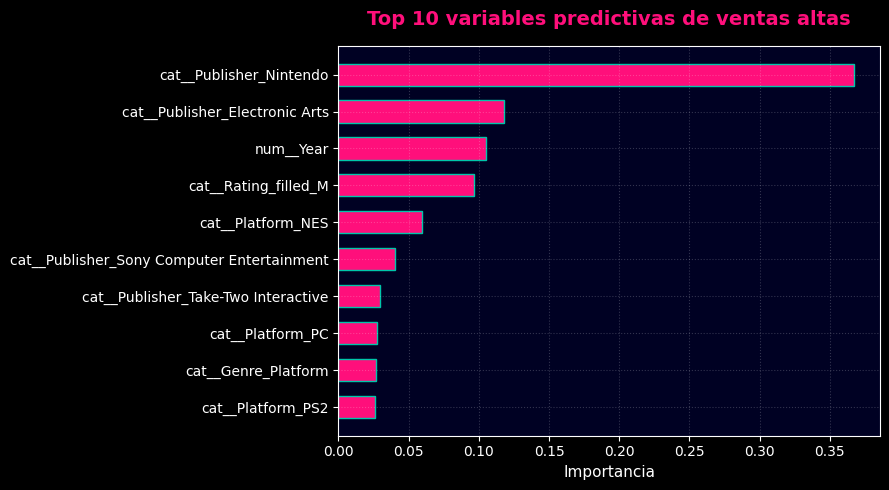

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer importancias
importances = model.named_steps["classifier"].feature_importances_
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Ordenar top 10
idx = np.argsort(importances)[::-1][:10]

# --- Estilo visual acorde a la presentación ---
plt.style.use("dark_background")
plt.figure(figsize=(9,5))
plt.rcParams.update({
    'axes.facecolor': '#000123',   # fondo del gráfico
    'figure.facecolor': '#000123', # fondo total
    'text.color': '#ffffff',
    'axes.labelcolor': '#ffffff',
    'xtick.color': '#ffffff',
    'ytick.color': '#ffffff'
})

# Barras fucsia con bordes suaves y tono de contraste
plt.barh(range(len(idx)), importances[idx][::-1],
         color="#ff0f7b", edgecolor="#00c6aa", height=0.6)

# Etiquetas
plt.yticks(range(len(idx)), feature_names[idx][::-1], fontsize=10)
plt.xlabel("Importancia", fontsize=11, color="#ffffff")
plt.title("Top 10 variables predictivas de ventas altas",
          fontsize=14, color="#ff0f7b", weight="bold", pad=15)

# Líneas sutiles y márgenes
plt.grid(alpha=0.2, color="#ffffff", linestyle=":")
plt.tight_layout()
plt.show()



Conclusiones

El modelo de árbol de decisión se utilizó para explorar si las variables conocidas antes del lanzamiento pueden anticipar el éxito comercial de un videojuego.
Para ello, se definió la variable objetivo ventas_altas, donde un valor de 1 indica que el título superó 1 millón de copias vendidas a nivel global.

El dataset muestra un fuerte desbalance (≈12 % de juegos exitosos y 88 % con ventas bajas), lo que limita la capacidad predictiva del modelo sin técnicas adicionales de balanceo.

Los resultados principales fueron:

Precisión global (accuracy): 0.88

Precision (clase 1 – ventas altas): 0.54

Recall (clase 1 – ventas altas): 0.10

F1-score (clase 1): 0.17

Esto indica que el modelo acierta bien los casos de ventas bajas, pero tiene dificultad para identificar los títulos más exitosos, lo cual es esperable dada su menor representación en los datos.

En cuanto a las variables más influyentes, se observa que:

Publisher (principalmente Nintendo y Electronic Arts) es el factor con mayor peso predictivo, reflejando la relevancia del respaldo de grandes distribuidoras.

Año de lanzamiento y plataforma también aportan información relevante, indicando que el contexto temporal y el tipo de consola influyen significativamente en las ventas.

El género y el rating tienen un rol secundario, aunque ayudan a matizar el comportamiento de los títulos exitosos.

En síntesis, los resultados nos indican que las características pre-lanzamiento aportan señales útiles sobre el potencial comercial de un juego, pero no son suficientes por sí solas para predecir el éxito, dado que factores posteriores al lanzmaiento como marketing, reseñas o tendencias culturales impactan fuertemente en las ventas reales.

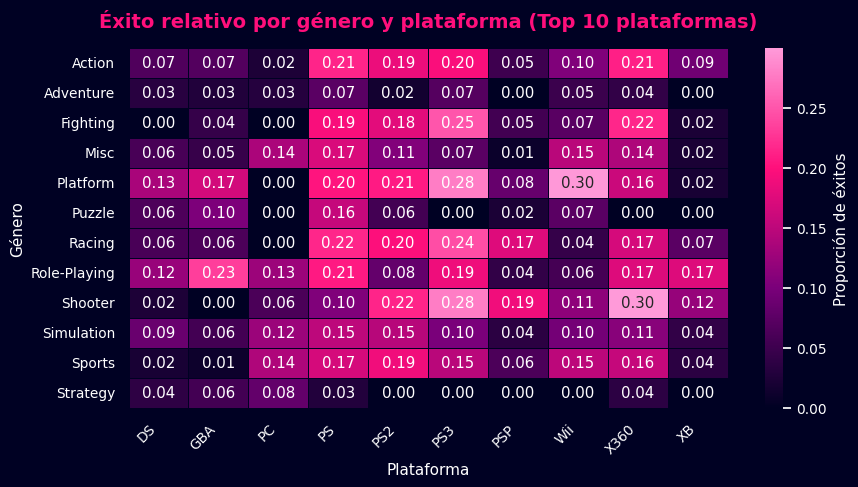

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#  Paleta de tu presentación
FONDO = "#000123"      # Azul oscuro (background)
FUCSIA = "#ff0f7b"     # Color principal
TEXTO = "#ffffff"      # Blanco
CONTRASTE = "#00c6aa"  # Verde agua (opcional para detalles)

#  Seleccionar las plataformas más populares (Top 10)
popular_platforms = df_pl["Platform"].value_counts().head(10).index

pivot_popular = (
    df_pl[df_pl["Platform"].isin(popular_platforms)]
    .groupby(["Genre", "Platform"])["ventas_altas"]
    .mean()
    .unstack()
    .fillna(0)
)

# Crear colormap personalizado (de oscuro → violeta → fucsia → rosa)
fucsia_cmap = LinearSegmentedColormap.from_list(
    "fucsia_cmap", [FONDO, "#7a007a", FUCSIA, "#ff9ad9"]
)

#  Configurar estilo general
plt.style.use("dark_background")
sns.set(font_scale=0.9)

fig, ax = plt.subplots(figsize=(9,5))
fig.patch.set_facecolor(FONDO)
ax.set_facecolor(FONDO)

#  Crear el heatmap
hm = sns.heatmap(
    pivot_popular,
    cmap=fucsia_cmap,
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    linecolor=FONDO,
    cbar=True,
    cbar_kws={'label': 'Proporción de éxitos'}
)

#  Estilos de títulos y ejes
ax.set_title("Éxito relativo por género y plataforma (Top 10 plataformas)",
             fontsize=14, color=FUCSIA, weight="bold", pad=15)
ax.set_xlabel("Plataforma", fontsize=11, color=TEXTO)
ax.set_ylabel("Género", fontsize=11, color=TEXTO)
ax.tick_params(colors=TEXTO)
plt.xticks(rotation=45, ha="right", color=TEXTO)
plt.yticks(color=TEXTO)

#  Ajustes del colorbar
cbar = hm.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color=TEXTO)
for t in cbar.ax.get_yticklabels():
    t.set_color(TEXTO)
cbar.set_label("Proporción de éxitos", color=TEXTO)

#  Detalles visuales extra (bordes sutiles, grid)
for spine in ax.spines.values():
    spine.set_edgecolor(CONTRASTE)
plt.grid(alpha=0.15, color=TEXTO, linestyle=":")

plt.tight_layout()
plt.show()


/tmp/ipython-input-2651594609.py:31: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(


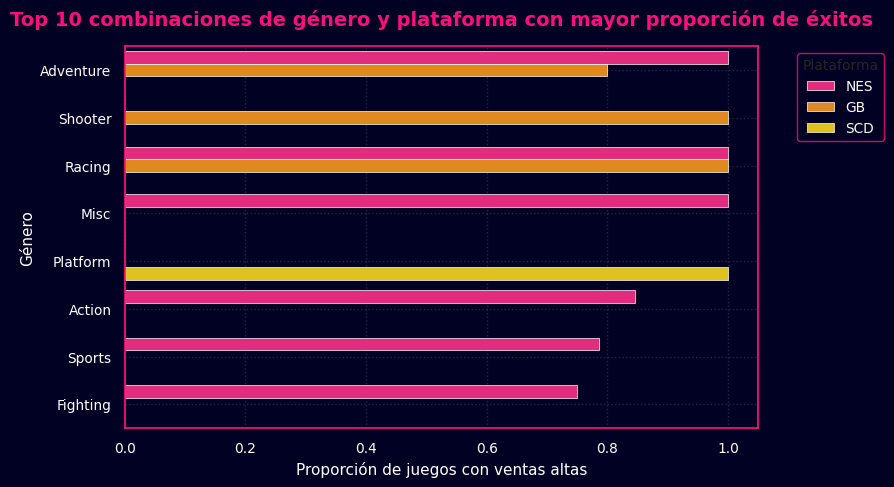

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🎨 Paleta personalizada (Tython warm edition)
FONDO = "#000123"      # Fondo oscuro
FUCSIA = "#ff0f7b"     # Color principal (fucsia)
TEXTO = "#ffffff"      # Blanco para texto
NARANJA = "#ff8c00"    # Naranja cálido
AMARILLO = "#ffd700"   # Amarillo brillante

# 🔹 Agrupar y mostrar las 10 combinaciones más exitosas
combos = (
    df_pl.groupby(["Genre", "Platform"])["ventas_altas"]
    .mean()
    .reset_index()
    .sort_values("ventas_altas", ascending=False)
    .head(10)
)

# 🔹 Configurar estilo general
plt.style.use("dark_background")
sns.set(font_scale=0.9)

fig, ax = plt.subplots(figsize=(9,5))
fig.patch.set_facecolor(FONDO)
ax.set_facecolor(FONDO)

# 🔹 Paleta personalizada fucsia → naranja → amarillo
custom_palette = [FUCSIA, NARANJA, AMARILLO, "#ff69b4", "#ffa500"]

sns.barplot(
    data=combos,
    x="ventas_altas",
    y="Genre",
    hue="Platform",
    palette=custom_palette,
    edgecolor="#ffffff",
    linewidth=0.5
)

# 🔹 Estilos de texto y ejes
ax.set_title("Top 10 combinaciones de género y plataforma con mayor proporción de éxitos",
             fontsize=14, color=FUCSIA, weight="bold", pad=15)
ax.set_xlabel("Proporción de juegos con ventas altas", fontsize=11, color=TEXTO)
ax.set_ylabel("Género", fontsize=11, color=TEXTO)
ax.tick_params(colors=TEXTO)

# 🔹 Leyenda personalizada
legend = plt.legend(
    title="Plataforma",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    facecolor=FONDO,
    edgecolor=FUCSIA,
    labelcolor=TEXTO,
    title_fontsize=10
)
plt.setp(legend.get_texts(), color=TEXTO)

# 🔹 Líneas y bordes sutiles
for spine in ax.spines.values():
    spine.set_edgecolor(FUCSIA)
plt.grid(alpha=0.15, color=TEXTO, linestyle=":")

plt.tight_layout()
plt.show()


#Claves del éxito comercial pre-lanzamiento
Los resultados indican que el éxito comercial no depende solo del género o la calidad, sino del equilibrio entre plataforma, género y publisher.
Las consolas de Nintendo y Sony concentran la mayor proporción de títulos exitosos, especialmente en géneros Sports y Action, respaldando la fuerza de sus ecosistemas de marca y fidelización.